# Analysis of the result

### Imports

In [1]:
import sys
sys.path.append(r"C:/Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence/")

from plot import plot_evolution, plot_histogram, plot_randomized_evolution, plot_hist_by_phenotype, plot_diadic_pattern, plot_bar_diadic_pattern
from analysis import histogram, measure_global, compute_xhi, compute_xhi_mean
from graph import Network
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from dataset import Dataset, measure_frequency_diadic_pattern
import os

import pymc as pm
import arviz as az

### Parameters

In [2]:
in_dir = r"../out/RTH_E3O2P21R12T17_Empty_L10_C750_S75_T0.25/"
net = Network()
net.reload_with_stack(in_dir)
name = net.name
parameters = net.parameters
oper = net.oper
last_dt = Dataset("local", oper.iter_number)
last_dt.init_with_network(net)
n = parameters["Community size"]
os.makedirs("../plot/" + name + "/", exist_ok=True)

### Analysis

#### Global saturation evolution

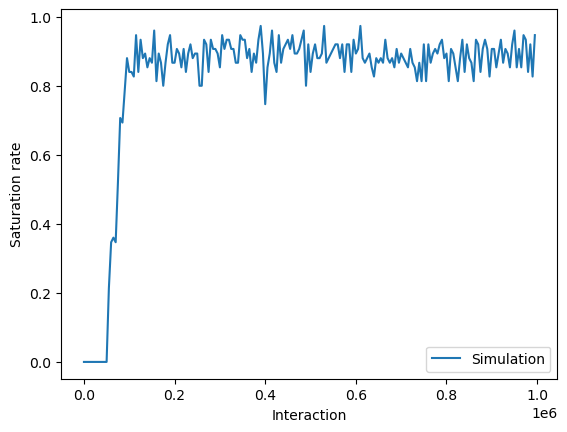

In [3]:
ax = plt.subplot(1, 1, 1)
plot_evolution(ax, "Saturation rate", oper, start=0, end=len(oper), step=5000, parameters=parameters, color="tab:blue", label="Simulation")
plt.legend()
plt.show()
#plt.savefig("./plot/" + name + "/" + "saturation_rate_evolution.png")

#### Global asymmetry rate evolution

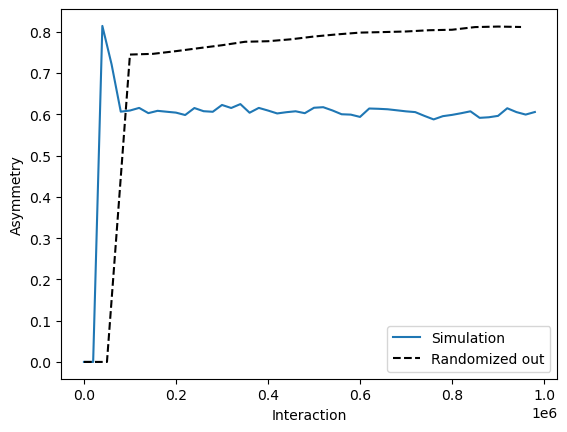

In [4]:
ax = plt.subplot(1, 1, 1)
plot_evolution(ax, "Asymmetry", oper, start=0, end=len(oper), step=20000, parameters=parameters, color="tab:blue", label="Simulation")
plot_randomized_evolution(ax, "Asymmetry", oper, start=0, end=len(oper), step=50000, parameters=parameters, color="k", linestyle="dashed", label="Randomized out")
plt.legend()
plt.show()
#plt.savefig("./plot/"  + name + "/" + "global_asymmetry_evolution.png")

#### Individual asymmetry rate evolution

In [5]:
t, l = oper.resolve(-1)
#random_value = measure_global("Individual asymmetry", t, l, parameters, random=True, niter=25, mode="i&&o", mc_iter=150)

In [6]:
#print("Individual asymmetry rate: ", measure_global("Individual asymmetry", t, l , parameters))
#print("Randomized result: ", random_value)

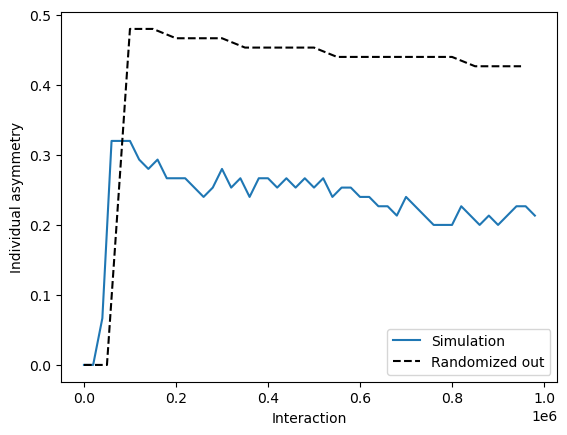

In [3]:
ax = plt.subplot(1, 1, 1)
#ax.hlines(random_value, xmin=0, xmax=len(oper), linestyles="dashed", colors="k", label="Randomized in&out (last)")
plot_evolution(ax, "Individual asymmetry", oper, start=0, end=len(oper), step=20000, parameters=parameters, color="tab:blue", label="Simulation")
plot_randomized_evolution(ax, "Individual asymmetry", oper, start=0, end=len(oper), step=50000, parameters=parameters, color="k", linestyle="dashed", label="Randomized out")
plt.legend()
plt.show()
#plt.savefig("./plot/"  + name + "/" + "individual_asymmetry_evolution.png")

#### State at a specific interaction number

In [3]:
inter = len(oper) # Interaction number at which we want to plot
final_trust, final_link = oper.resolve(inter)
ph_mean = histogram(final_trust, parameters)
mean = ph_mean["Global"]

In [4]:
print("Working with: ", in_dir)
print("Number of interaction: ", inter)
print("Asymmetry rate: ", measure_global("Asymmetry", final_trust, final_link, parameters))
print("Individual asymmetry rate: ", measure_global("Individual asymmetry", final_trust, final_link, parameters))
print("Out preserving ind. asymmetry: ", measure_global("Individual asymmetry", final_trust, final_link, parameters, random=True, niter=1000, mode="o"))
print("Saturation rate: ", measure_global("Saturation rate", final_trust, final_link, parameters))
link_stat = measure_global("Number of link", final_trust, final_link, parameters)
print("Mean number of link per agent: ", link_stat[0])
print("Standard deviation number of link per agent: ", link_stat[1])
print("Mean number of interaction per link: ", 2 * inter / (n * (n-1)))

Working with:  ../out/RTH_E3O2P21R12T17_Empty_L10_C750_S75_T0.25/
Number of interaction:  1000000
Asymmetry rate:  0.6063492063492063
Individual asymmetry rate:  0.21333333333333335
Out preserving ind. asymmetry:  0.4266666666666667
Saturation rate:  0.8933333333333333
Mean number of link per agent:  23.413333333333334
Standard deviation number of link per agent:  34.55700604315522
Mean number of interaction per link:  360.36036036036035


##### Etas and Xhi distribution

In the article of Tamarit *et al.* (2022) the Dunbar's circle are given it term of **cost** which is defined in the context of their resource allocation framework.

This notion can be implemented in our model denoting $s$ as the cost and $t$ the trust value of a link:

$$s_{ij} = t_{ij} - t_{min}$$

where $t_{min}$ is the minimum value of trust for a link to appear 

Estimated eta:  1.0697287984330046


<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_11680\3871627361.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


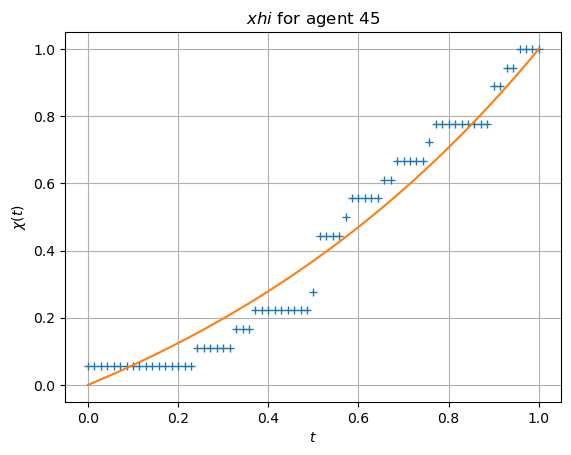

In [11]:
agent = 45

xhi = compute_xhi(agent , final_trust, parameters)
size = xhi.size
t = np.arange(size)
t_norm = t / (size-1)
model = lambda i, eta:  (np.exp(eta * i / (size-1)) - 1) / (np.exp(eta) - 1)
popt, _ = curve_fit(model, np.arange(0, size), xhi)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi, "+", label="data")
plt.plot(t_norm, model(t, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for agent {}".format(agent))
plt.grid()
plt.show()
#plt.savefig("./plot/" + "Poor chi fit.png")

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_11680\3748624311.py:12: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi(t)$")


Estimated eta:  3.6230848001653926


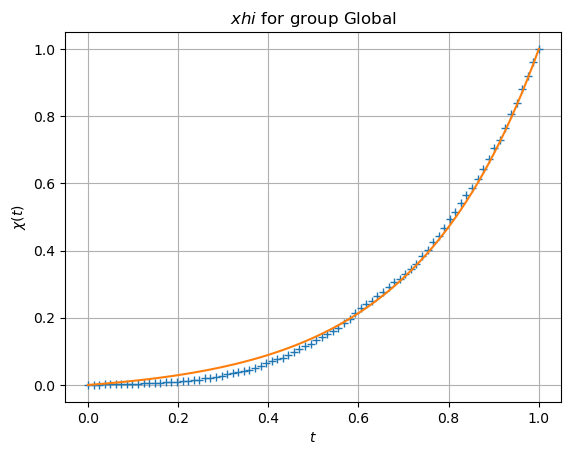

In [12]:
selector = "Global"
xhi_mean = compute_xhi_mean(final_trust, parameters, ph_selector=selector)
size = xhi_mean.size
t = np.arange(size)
t_norm = t/(size-1)
model = lambda i, eta:  (np.exp(eta * i / (size-1)) - 1) / (np.exp(eta) - 1)
popt, _ = curve_fit(model, t, xhi_mean)
print("Estimated eta: ", popt[0])
plt.plot(t_norm, xhi_mean, "+", label="data")
plt.plot(t_norm, model(t, popt[0]), label="model")
plt.xlabel("$t$")
plt.ylabel("$\chi(t)$")
plt.title("$xhi$ for group {}".format(selector))
plt.grid()
plt.show()
#plt.savefig("./plot/" + "Global chi fit.png")


In [13]:
xhi_mean = compute_xhi_mean(final_trust, parameters)
size = xhi_mean.size
t_norm = np.arange(size) / (size-1)
with pm.Model() as model:
    # Priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    etas = pm.Normal("etas", mu=2.5, sigma=4)

    # Likelihood
    likelihood = pm.Normal("xhi mean", mu= (np.exp(etas * t_norm) - 1) / (np.exp(etas) - 1), sigma=sigma, observed=xhi_mean)

    # Inference
    idata = pm.sample(3000, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, etas]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 28 seconds.


In [14]:
az.summary(idata, kind="stats", round_to=4)

,mean,sd,hdi_3%,hdi_97%
etas,3.6229,0.0308,3.5652,3.6811
sigma,0.0158,0.0013,0.0134,0.0180


<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Matthieu\AppData\Local\Temp\ipykernel_11680\1465592131.py:14: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\eta$")


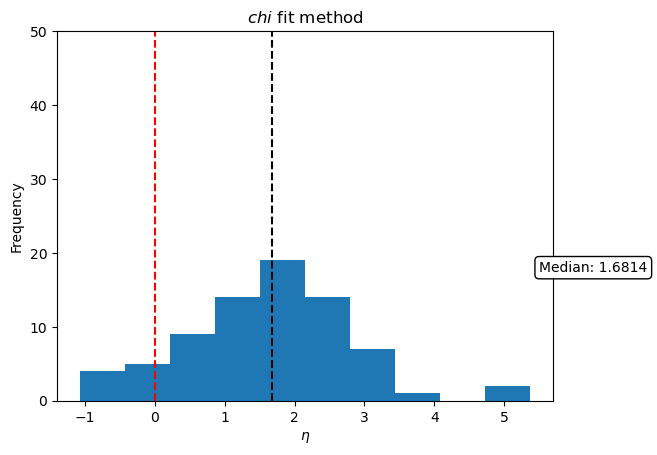

In [15]:
com_size = parameters["Community size"]
etas_2 = np.zeros(com_size)
for i in range(com_size):
    xhi = compute_xhi(i, final_trust, parameters)
    size = xhi.size
    model = lambda j, eta: (np.exp(eta * j / (size-1)) - 1) / (np.exp(eta) - 1)
    popt, _ = curve_fit(model, np.arange(0, size), xhi)
    etas_2[i] = popt[0]

plt.hist(etas_2)
plt.vlines([0, np.median(etas_2)], 0, 55, linestyles="dashed", colors=["r", "k"])
plt.ylim([0, 50])
plt.title("$chi$ fit method")
plt.xlabel("$\eta$")
plt.ylabel("Frequency")
plt.text(5.5, 18, "Median: {}".format(round(np.median(etas_2), 4)),
         ha="left", va="center",
         bbox=dict(boxstyle="round",
                   fc=(1,1,1))
         )
#plt.savefig("./plot/" + name + "/" + "eta_histogram_fit.png")
plt.show()

##### Etas

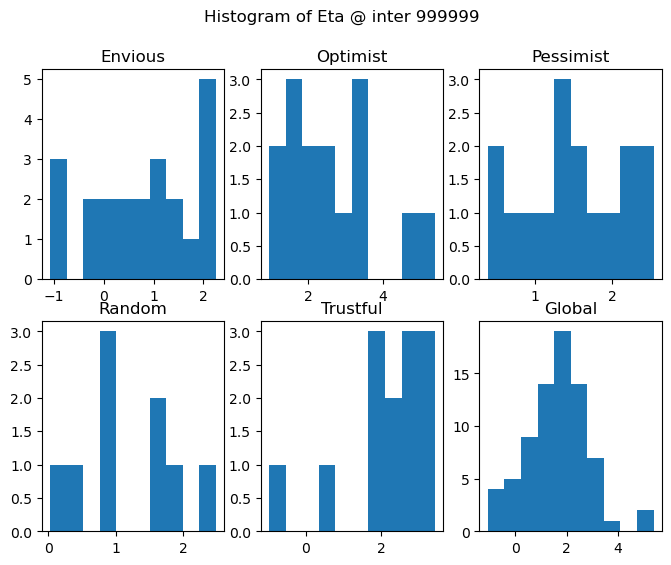

In [17]:
plot_hist_by_phenotype(last_dt, "Eta")
plt.show()

##### Centrality

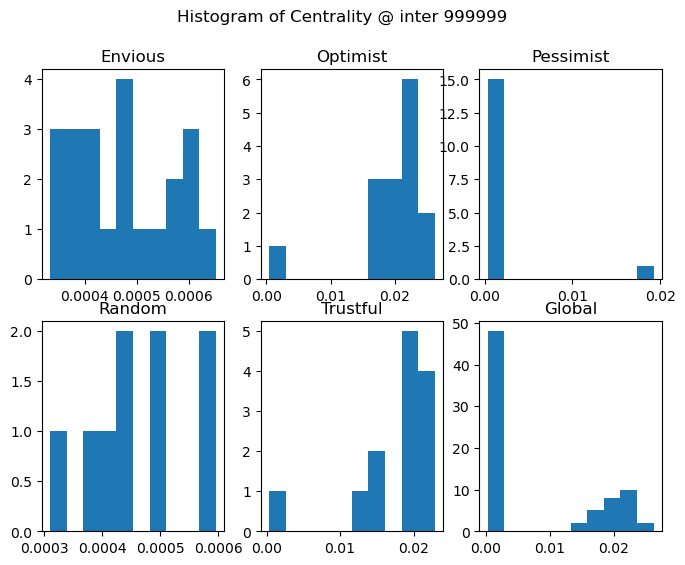

In [ ]:
plot_hist_by_phenotype(last_dt, "Centrality")
plt.show()

##### Diadic pattern

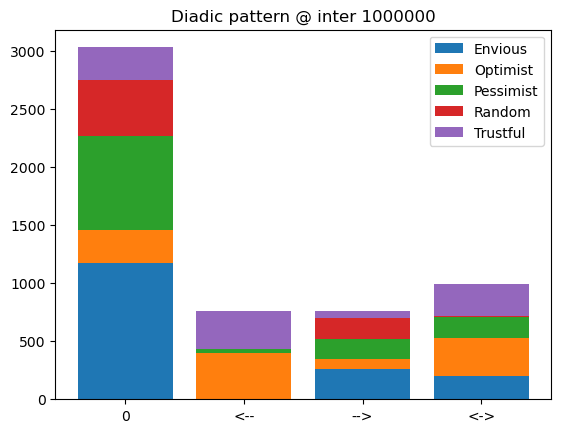

In [5]:
di_pattern_freq = measure_frequency_diadic_pattern(final_link, net.phenotypes_table, inter)
plot_bar_diadic_pattern(di_pattern_freq)
plt.show()

##### Trust Histogram

C:\Users/Matthieu/Documents/_Travail/Stages/Stage M1/Workspace/cooperation_emergence\plot.py:43: RuntimeWarning: divide by zero encountered in log
  ax[i, j].plot(np.log(data), '+', **kwargs)


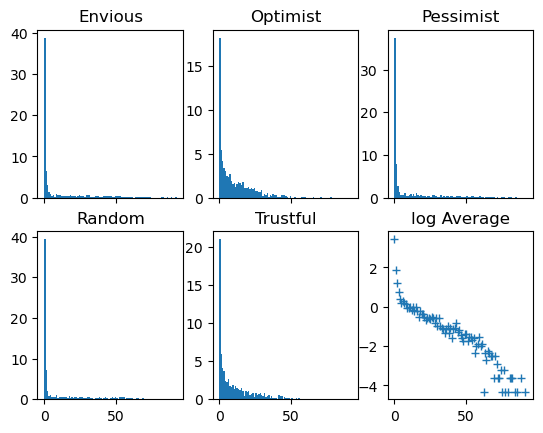

In [18]:
fig, ax = plot_histogram(ph_mean, parameters, log=False, color="tab:blue")
#plt.savefig("./plot/" + name + "_histogram_" + str(inter) + ".png" )